<a href="https://colab.research.google.com/github/sajjad73hajizade/shirazU-learn/blob/main/Copy_of_patternproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 15.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data
import rasterio
from osgeo import gdal
from skimage import exposure
from skimage.exposure import match_histograms
# import colorsys
import cv2
import math

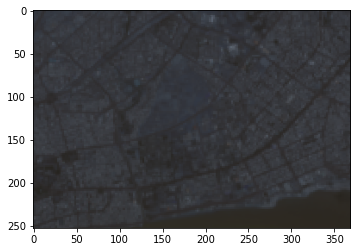

In [3]:
#Build ms image
red_band = rasterio.open('L8_30_RED1.tif').read(1)

green_band = rasterio.open('L8_30_GREEN1.tif').read(1)

blue_band = rasterio.open('L8_30_BLUE1.tif').read(1)

pan_band = rasterio.open('L8_15_pan.tif').read(1)

# MS_image = np.dstack((red_band, green_band, blue_band))

MS_image = cv2.merge([blue_band, green_band, red_band])

plt.imshow(MS_image)
plt.show()

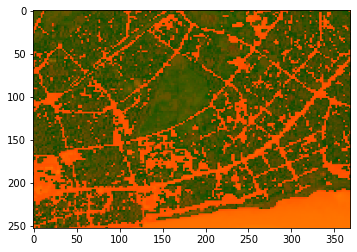

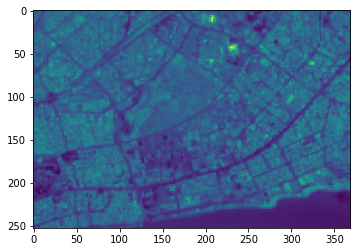

In [4]:
#RGB to HSI
def RGB_TO_HSI(img):

    with np.errstate(divide='ignore', invalid='ignore'):

        #Load image with 32 bit floats as variable type
        bgr = np.float32(img)/255

        #Separate color channels
        blue = bgr[:,:,0]
        green = bgr[:,:,1]
        red = bgr[:,:,2]

        #Calculate Intensity
        def calc_intensity(red, blue, green):
            return np.divide(blue + green + red, 3)

        #Calculate Saturation
        def calc_saturation(red, blue, green):
            minimum = np.minimum(np.minimum(red, green), blue)
            saturation = 1 - (3 / (red + green + blue + 0.001) * minimum)

            return saturation

        #Calculate Hue
        def calc_hue(red, blue, green):
            hue = np.copy(red)

            for i in range(0, blue.shape[0]):
                for j in range(0, blue.shape[1]):
                    hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) / \
                                math.sqrt((red[i][j] - green[i][j])**2 +
                                        ((red[i][j] - blue[i][j]) * (green[i][j] - blue[i][j])))
                    hue[i][j] = math.acos(hue[i][j])

                    if blue[i][j] <= green[i][j]:
                        hue[i][j] = hue[i][j]
                    else:
                        hue[i][j] = ((360 * math.pi) / 180.0) - hue[i][j]

            return hue

        #Merge channels into picture and return image
        hsi = cv2.merge((calc_hue(red, blue, green), calc_saturation(red, blue, green), calc_intensity(red, blue, green)))
        return hsi, calc_intensity(red, blue, green)

hsi_ms, intensity_band = RGB_TO_HSI(MS_image)

plt.imshow(hsi_ms)
plt.show()

plt.imshow(intensity_band)
plt.show()





---


[1]   Apply DWT to MS image and calculate the approximation
and detail coefficients


---



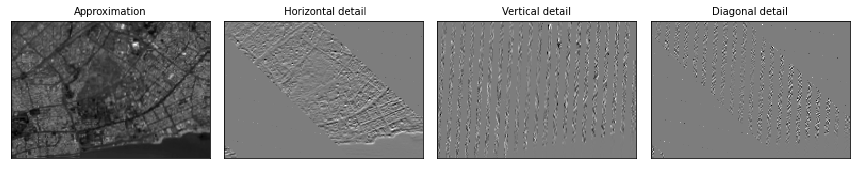

In [11]:
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(blue_band, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])



fig.tight_layout()
plt.show()




---
[2]   Similarly apply DWT to PAN image and decompose it into
their respective approximation and detail coefficients.


---




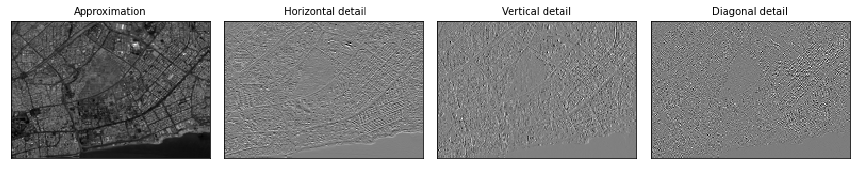

In [12]:
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs21 = pywt.dwt2(pan_band, 'bior1.3')
LL1, (LH1, HL1, HH1) = coeffs21
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])



fig.tight_layout()

plt.show()

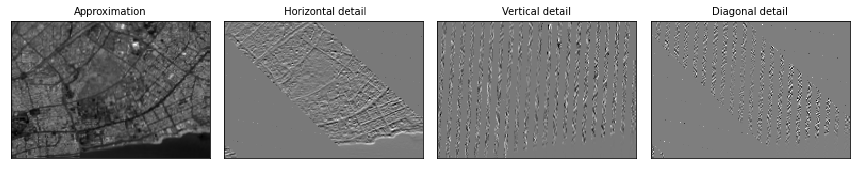

In [13]:
#intensity component of the MS Detail Coefficients
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs211 = pywt.dwt2(intensity_band, 'bior1.3')
LL1, (LH1, HL1, HH1) = coeffs211
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])



fig.tight_layout()

plt.show()



---
[3]   Approximation coefficient of PAN image is replaced with
that of MS image


---




In [14]:
pan_coe = list(coeffs21)
ms_coe = list(coeffs211)
pan_coe[0] = ms_coe[0]



---
[4]  **Each pair of the detail coefficients obtained in step (1) & (2)
are fused by using the proposed fusion rule based on spatial
frequency given in steps (5)–(9).**


---






---

[5]  PAN Detail Coefficients (PDC) is histogram matched with the
intensity component of the MS Detail Coefficients (MDC).


---



In [15]:
#Horizontal detail
image = pan_coe[1][0]
reference = ms_coe[1][0]

matched_pan_H = match_histograms(image, reference,multichannel=False,)

np.concatenate(matched_pan_H).astype(None)

len_num = len(matched_pan_H)
i = 0
while i < len_num:
  pan_coe[1][0][i] = matched_pan_H[i]
  i += 1

In [16]:
#Vertical detail
image = pan_coe[1][1]
reference = ms_coe[1][1]

matched_pan_V = match_histograms(image, reference)
np.concatenate(matched_pan_V).astype(None)

len_num = len(matched_pan_V)
i = 0
while i < len_num:
  pan_coe[1][1][i] = matched_pan_V[i]
  i += 1

In [18]:
#Diagonal detail
image = pan_coe[1][2]
reference = ms_coe[1][2]

matched_pan_D = match_histograms(image, reference)
np.concatenate(matched_pan_D).astype(None)

len_num = len(matched_pan_D)
i = 0
while i < len_num:
  pan_coe[1][2][i] = matched_pan_D[i]
  i += 1

# print(pan_coe[1][0][0][0])



---
[6]  Spatial Frequency of both, histogram matched PAN Detail
Coefficients (FSPC ) and the intensity value of MS Detail coef
ficients (FSMC ) are calculated using Eqs. (1)–(3).


---




In [23]:
# PAN FS
#get the number of rows
M = len(pan_coe[1][0])  #129
#get the number of columns
N = len(pan_coe[1][0][0]) #187
#-------------------------------------------------------------------
# PAN VERTICAL
x = 0
y = 1
sf_pan = 0
while x < M:
  while y < N:
    sf_pan1 = (pan_coe[1][0][x][y] - pan_coe[1][0][x][y-1])**2
    sf_pan += sf_pan1
    y += 1

  x += 1

FR = np.sqrt(sf_pan/(M*N))

x = 1
y = 0
sf_pan = 0
while y < N:
  while x < M:
    sf_pan1 = (pan_coe[1][0][x][y] - pan_coe[1][0][x-1][y])**2
    sf_pan += sf_pan1
    x += 1

  y += 1

FC = np.sqrt(sf_pan/(M*N))

FS_pan_vertical = np.sqrt((FR**2) + (FC**2))


#-------------------------------------------------------------------
# PAN HORIZONTAL
x = 0
y = 1
sf_pan = 0
while x < M:
  while y < N:
    sf_pan1 = (pan_coe[1][1][x][y] - pan_coe[1][1][x][y-1])**2
    sf_pan += sf_pan1
    y += 1

  x += 1

FR = np.sqrt(sf_pan/(M*N))

x = 1
y = 0
sf_pan = 0
while y < N:
  while x < M:
    sf_pan1 = (pan_coe[1][1][x][y] - pan_coe[1][1][x-1][y])**2
    sf_pan += sf_pan1
    x += 1

  y += 1

FC = np.sqrt(sf_pan/(M*N))

FS_pan_horizontal = np.sqrt((FR**2) + (FC**2))

#-------------------------------------------------------------------
# PAN DIAGONAL
x = 0
y = 1
sf_pan = 0
while x < M:
  while y < N:
    sf_pan1 = (pan_coe[1][2][x][y] - pan_coe[1][2][x][y-1])**2
    sf_pan += sf_pan1
    y += 1

  x += 1

FR = np.sqrt(sf_pan/(M*N))

x = 1
y = 0
sf_pan = 0
while y < N:
  while x < M:
    sf_pan1 = (pan_coe[1][2][x][y] - pan_coe[1][2][x-1][y])**2
    sf_pan += sf_pan1
    x += 1

  y += 1

FC = np.sqrt(sf_pan/(M*N))

FS_pan_diagonal = np.sqrt((FR**2) + (FC**2))


In [24]:
# NS SF
#get the number of rows
M = len(ms_coe[1][0])  #129
#get the number of columns
N = len(ms_coe[1][0][0]) #187
#-------------------------------------------------------------------
# MS VERTICAL
x = 0
y = 1
sf_ms = 0
while x < M:
  while y < N:
    sf_ms1 = (ms_coe[1][0][x][y] - ms_coe[1][0][x][y-1])**2
    sf_ms += sf_ms1
    y += 1

  x += 1

FR = np.sqrt(sf_ms/(M*N))

x = 1
y = 0
sf_pan = 0
while y < N:
  while x < M:
    sf_ms1 = (ms_coe[1][0][x][y] - ms_coe[1][0][x-1][y])**2
    sf_ms += sf_ms1
    x += 1

  y += 1

FC = np.sqrt(sf_ms/(M*N))

FS_ms_vertical = np.sqrt((FR**2) + (FC**2))


#-------------------------------------------------------------------
# MS HORIZONTAL
x = 0
y = 1
sf_ms = 0
while x < M:
  while y < N:
    sf_ms1 = (ms_coe[1][1][x][y] - ms_coe[1][1][x][y-1])**2
    sf_ms += sf_ms1
    y += 1

  x += 1

FR = np.sqrt(sf_ms/(M*N))

x = 1
y = 0
sf_ms = 0
while y < N:
  while x < M:
    sf_ms1 = (ms_coe[1][1][x][y] - ms_coe[1][1][x-1][y])**2
    sf_ms += sf_ms1
    x += 1

  y += 1

FC = np.sqrt(sf_ms/(M*N))

FS_ms_horizontal = np.sqrt((FR**2) + (FC**2))

#-------------------------------------------------------------------
# MS DIAGONAL
x = 0
y = 1
sf_ms = 0
while x < M:
  while y < N:
    sf_ms1 = (ms_coe[1][2][x][y] - ms_coe[1][2][x][y-1])**2
    sf_ms += sf_ms1
    y += 1

  x += 1

FR = np.sqrt(sf_ms/(M*N))

x = 1
y = 0
sf_ms = 0
while y < N:
  while x < M:
    sf_ms1 = (ms_coe[1][2][x][y] - ms_coe[1][2][x-1][y])**2
    sf_ms += sf_ms1
    x += 1

  y += 1

FC = np.sqrt(sf_ms/(M*N))

FS_ms_diagonal = np.sqrt((FR**2) + (FC**2))


In [25]:
print('FS_pan_vertical' + ' = ' + str(FS_pan_vertical))
print('FS_pan_horizontal' + ' = ' + str(FS_pan_horizontal))
print('FS_pan_diagonal' + ' = ' + str(FS_pan_diagonal))
print('FS_ms_vertical' + ' = ' + str(FS_ms_vertical))
print('FS_ms_horizontal' + ' = ' + str(FS_ms_horizontal))
print('FS_ms_diagonal' + ' = ' + str(FS_ms_diagonal))

FS_pan_vertical = 5.382826610807258e-06
FS_pan_horizontal = 6.494857166261483e-06
FS_pan_diagonal = 1.490823219825912e-06
FS_ms_vertical = 5.248732212627812e-06
FS_ms_horizontal = 5.645028759799264e-06
FS_ms_diagonal = 2.109488493963827e-06




---
[7] Let FSMC be the Normalized spatial frequencies of the Inten sity value of MS Detail Coefficients


---

[8] Let FSPC be the Normalized spatial frequencies of histogram matched PAN Detail Coefficients


---




In [26]:
#Horizontal
Fsmc = FS_ms_horizontal
Fspc = FS_pan_horizontal
NFsmc_H = Fsmc /(Fsmc + Fspc)
NFspc_H = Fspc / (Fsmc + Fspc)

In [27]:
#Vertical
Fsmc = FS_ms_vertical
Fspc = FS_pan_vertical
NFsmc_V = Fsmc /(Fsmc + Fspc)
NFspc_V = Fspc / (Fsmc + Fspc)

In [28]:
#Diagonal
Fsmc = FS_ms_diagonal
Fspc = FS_pan_diagonal
NFsmc_D = Fsmc /(Fsmc + Fspc)
NFspc_D = Fspc / (Fsmc + Fspc)



---
[9] Then the fused Detail coefficients (Ifdc) will be equal to


---





In [29]:
# Pdc = pan_coe
# Mdc = ms_coe
#Horizontal
Ifdc_H = ms_coe[1][0] * NFsmc_H + pan_coe[1][0] * NFspc_H

#Vertical
Ifdc_V = ms_coe[1][1] * NFsmc_V + pan_coe[1][1] * NFspc_V

#Diagonal
Ifdc_D = ms_coe[1][2] * NFsmc_D + pan_coe[1][2] * NFspc_D



---
[10] Apply Inverse DWT to fused detail coefficients (Ifdc) and replaced MS Approximation Coefficient to get the fused image (If)


---




In [30]:
#Horizontal
len_num1 = len(Ifdc_H)
i = 0
while i < len_num1:
  ms_coe[1][0][i] = Ifdc_H[i]
  i += 1

#Vertical
len_num2 = len(Ifdc_V)
i = 0
while i < len_num2:
  ms_coe[1][1][i] = Ifdc_V[i]
  i += 1

#Diagonal
len_num3 = len(Ifdc_D)
i = 0
while i < len_num3:
  ms_coe[1][2][i] = Ifdc_D[i]
  i += 1

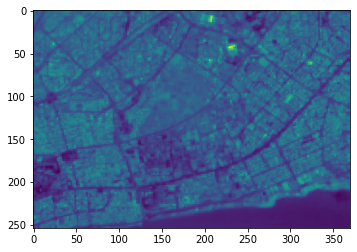

In [32]:
#Invers DWT
fused_image = pywt.idwt2(ms_coe, 'bior1.3')

plt.imshow(fused_image)
plt.show()

In [33]:
SD = np.std(fused_image)
print(SD)

0.00010297814


In [49]:
from scipy.stats import entropy
base = 2  # work in units of bits

E = entropy(fused_image, base=base)
print(E)

[7.980639  7.978802  7.978414  7.9774737 7.976861  7.977297  7.97739
 7.978069  7.9786186 7.978327  7.97705   7.9775977 7.9783115 7.978577
 7.97821   7.9778814 7.9779277 7.9782147 7.976838  7.976136  7.975314
 7.975609  7.97537   7.973708  7.974997  7.977502  7.977373  7.978031
 7.9775515 7.9782853 7.9799867 7.9801016 7.9808254 7.9808893 7.980462
 7.980829  7.9818435 7.9810386 7.9808083 7.98069   7.980705  7.980101
 7.9811087 7.9818897 7.9815154 7.9820647 7.982751  7.982429  7.980911
 7.9803786 7.9817586 7.9807134 7.982137  7.983613  7.983663  7.983956
 7.984714  7.983998  7.984765  7.9840765 7.984274  7.9846797 7.983901
 7.9840164 7.9830694 7.9826345 7.982737  7.982345  7.9830303 7.9832377
 7.9844913 7.984474  7.984512  7.984299  7.9835043 7.982199  7.981494
 7.981143  7.981676  7.982005  7.982345  7.98306   7.9839945 7.9845476
 7.9840336 7.9835486 7.9829655 7.9829936 7.983398  7.9832387 7.982889
 7.983408  7.9841423 7.9845276 7.9839106 7.982092  7.982481  7.9824686
 7.982296  7.98249

In [53]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
# import tifffile
# tifffile.imwrite('fused_image.tiff', fused_image)

# tifffile.imwrite('hsi_ms.png', hsi_ms)